# **Importieren von Bibliotheken**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import CoolProp.CoolProp as CP
from CoolProp.Plots import PropertyPlot
import warnings


warnings.filterwarnings(
    "ignore"
)  # deaktiviert Warnungen (nicht für normale Arbeiten machen!)

# **Konstanten definieren**

In [3]:
fluid = "R717"  # Kältemittel

T_Vorlauf = 60 + 273.15  # Kondensator Vorlauftemperatur in K
T_Ruecklauf = 40 + 273.15  # Kondensator Ruecklauftemperatur in K (Annahme)
T_u = 4 + 273.15  # Umgebungstemperatur in K
T_c = 65 + 273.15  # Kondensator Temperatur in K (Annahme)
T_3sc = 55 + 273.15  # Kondensator Temperatur in K (Annahme)
T1_sh = 0 + 273.15  # Temperatur Überhizungung in K (Annahme)
T_2 = 105 + 273.15  # Temperatur Hochdruck in K

P_db = 310e3  # Wellenleistung bei Vollast in W
P_db2 = 171e3  # Wellensleistung bei Teillast in W
Q_h = 1000e3  # Heizleistung in W
p_c = 29.5e5  # Hochdruck in PA

# **Zustandspunkte berechnen**

In [4]:
def calc_ZP(T1_sh, T_2, T_3sc, p_0=3.7e5, p_c=29.5e5, fluid="R717"):
    p = np.zeros(5)
    T = np.zeros(5)
    h = np.zeros(5)
    s = np.zeros(5)
    rho = np.zeros(5)

    # Punkt 1: Austritt Verdampfer (überhitzt)
    p[0] = CP.PropsSI("P", "T", T1_sh, "Q", 1, fluid)  # Saugdruck
    T[0] = T1_sh  # Temperatur
    h[0] = CP.PropsSI("H", "T", T1_sh, "P", p_0, fluid)  # Enthalpie in J/kg
    s[0] = CP.PropsSI("S", "T", T1_sh, "P", p_0, fluid)  # Entropie in J/kg/K
    rho[0] = CP.PropsSI(
        "D", "T", T1_sh, "P", p_0, fluid
    )  # spezifisches Volumen in m³/kg

    # Punkt 2: Austritt Verdichter
    p[1] = p_c  # Hochdruck
    s2s = s[0]
    h2s = CP.PropsSI("H", "P", p[1], "S", s2s, fluid)  # isentrope Enthalpie
    T_2s = CP.PropsSI("T", "P", p[1], "H", h2s, fluid)  # isentrope Temperatur
    T[1] = T_2  # Temperatur
    s[1] = CP.PropsSI("S", "T", T[1], "P", p[1], fluid)  # isentrope Verdichtung
    h[1] = CP.PropsSI("H", "P", p[1], "S", s[1], fluid)  # isentrope Enthalpie
    rho[1] = CP.PropsSI(
        "D", "T", T[1], "P", p[1], fluid
    )  # spezifisches Volumen in m³/kg

    # Punkt 3: Austritt Kondensator
    p[2] = p[1]  # Hochdruck
    T[2] = T_3sc  # Temperatur
    h[2] = CP.PropsSI("H", "T", T[2], "P", p[2], fluid)  # Enthalpie
    s[2] = CP.PropsSI("S", "T", T[2], "P", p[2], fluid)  # Entropie
    rho[2] = CP.PropsSI(
        "D", "T", T[2], "P", p[2], fluid
    )  # spezifisches Volumen in m³/kg

    # Punkt 4: Austritt Drossel
    p[3] = p[0]  # Saugdruck
    h[3] = h[2]  # isenthalpische Drosselung
    T[3] = CP.PropsSI("T", "P", p[3], "H", h[3], fluid)  # Temperatur
    s[3] = CP.PropsSI("S", "P", p[3], "H", h[3], fluid)  # Entropie
    rho[3] = CP.PropsSI(
        "D", "P", p[3], "H", h[3], fluid
    )  # spezifisches Volumen in m³/kg

    # Punkt 5: Austritt Seperator
    p[4] = p[0]  # Saugdruck
    T[4] = CP.PropsSI("T", "P", p[4], "Q", 0, fluid)  # Temperatur
    h[4] = CP.PropsSI("H", "P", p[4], "Q", 0, fluid)  # Enthalpie
    s[4] = CP.PropsSI("S", "P", p[4], "Q", 0, fluid)  # Entropie
    rho[4] = CP.PropsSI("D", "P", p[4], "Q", 0, fluid)  # spezifisches Volumen in m³/kg

    return p, T, h, s, rho, T_2s, h2s

# **Tabelle von Zustandspunkten des Kreislaufs**

In [5]:
p, T, h, s, rho, T_2s, h2s = calc_ZP(T1_sh, T_2, T_3sc)

print("T_2s:", T_2s - 273.15)

df = pd.DataFrame(
    {
        "p in Pa": p,
        "p in bar": p * 1e-5,
        "T in K": T,
        "T in °C": T - 273.15,
        "h in J/kg": h,
        "h in kJ/kg": h * 1e-3,
        "s in J/(kg*K)": s,
        "s in kJ/(kg*K)": s * 1e-3,
        "rho in kg/m³:": rho,
    },
    index=np.arange(5),
)


display(df)

T_2s: 163.3353545898771


,p in Pa,p in bar,T in K,T in °C,h in J/kg,h in kJ/kg,s in J/(kg*K),s in kJ/(kg*K),rho in kg/m³:
0,4.292478e+05,4.292478,273.15,0.000000e+00,1.613340e+06,1613.340226,6192.322907,6.192323,2.946725
1,2.950000e+06,29.500000,378.15,1.050000e+02,1.776758e+06,1776.757839,5780.881788,5.780882,18.520423
2,2.950000e+06,29.500000,328.15,5.500000e+01,6.115423e+05,611.542251,2354.941070,2.354941,555.268775
3,4.292478e+05,4.292478,273.15,-1.705303e-13,6.115423e+05,611.542251,2456.829623,2.456830,16.075924
4,4.292478e+05,4.292478,273.15,-1.705303e-13,3.456749e+05,345.674939,1483.491485,1.483491,638.638205


# **Erstellung des Kältekreislaufs**
* Isentroperverdichtung in Scatterlines 
* Verdichterendtemperatur wird hier auf 105°C gesetzt gegeben durch Datenblatt von Verdichter
* Sammler im Kreislauf

In [6]:
h_gk = [0, 0, 0, 0]
p_gk = [0, 0, 0, 0]

p_gk[0] = CP.PropsSI("P", "T", 0 + 273.15, "Q", 1, fluid)  # Saugdruck
p_gk[1] = p[1]
p_gk[2] = p[2]
p_gk[3] = p_gk[0]
h_gk[0] = CP.PropsSI("H", "T", 0 + 273.15, "Q", 1, fluid)  # Saugenthalpie
h_gk[1] = h2s
h_gk[2] = CP.PropsSI("H", "T", 65 + 273.15, "Q", 0, fluid)  # Saugenthalpie
h_gk[3] = h_gk[2]  # isenthalpische Drosselung

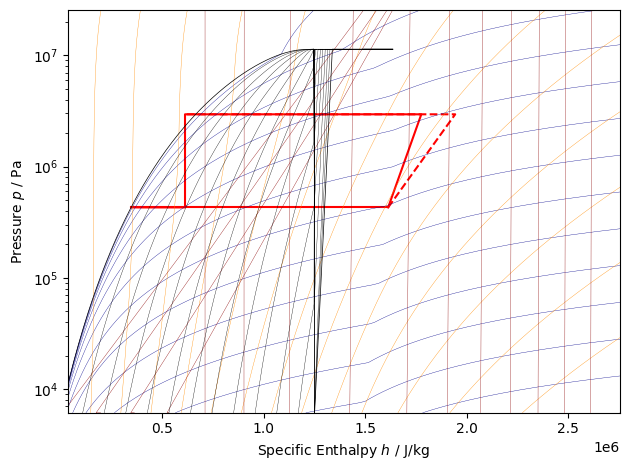

In [30]:
pp = PropertyPlot(fluid, "PH", unit_system="SI")
pp.calc_isolines()

df_zp = pd.concat([df[df.index == 0], df[df.index == 4]])
plt.plot(df["h in J/kg"], df["p in Pa"], "r")
plt.plot(df_zp["h in J/kg"], df_zp["p in Pa"], "r")
plt.plot([h[0], h2s, h[2]], [p[0], p[1], p[1]], "r--", label="isentrope Verdichtung")
pp.show()

# **Berechnung des Massenstroms sowie des COPs bei Voll- und Teillast**

In [8]:
# Berechnung des nötigen Massestroms
m_dot = Q_h / (h[1] - h[2])  # Massestrom in kg/s
m_dot_h = m_dot * 3600

# Berechnung der Kälteleistung
Q_c = m_dot * (h[0] - h[4])  # Kälteleistung in W
P_vs = m_dot * (h2s - h[0])
COP = Q_h / P_db  # Coefficient of Performance
COP_teillast = 0.5 * Q_h / P_db2  # Coefficient of Performance Teillast
COP_s = Q_c / P_vs  # Coefficient of Performance isentrop
COP_carnot = T_c / (T_c - T[0])

print(f"Massestrom: {m_dot:.2f} kg/s")
print(f"Massestrom: {m_dot_h:.2f} kg/h")
print(f"Kälteleistung: {Q_c / 1e3:.2f} kW")
print(f"Verdichterleistung isentrop: {P_vs / 1e3:.2f} kW")
print(f"COP Carnot: {COP_carnot:.2f}")
print(f"COP isentrop: {COP_s:.2f}")
print(f"COP: {COP:.2f}")
print(f"COP_teil: {COP_teillast:.2f} ")

Massestrom: 0.86 kg/s
Massestrom: 3089.56 kg/h
Kälteleistung: 1087.92 kW
Verdichterleistung isentrop: 283.61 kW
COP Carnot: 5.20
COP isentrop: 3.84
COP: 3.23
COP_teil: 2.92 


# **Darstellung COP gegen Heizleistung**
- Verhalten COP gegenüber Heizleistungsbereich 

In [9]:
def calc_cop(P_min, P_max):
    Q_Heizbereich = np.linspace(500e3, 1000e3, num=10)
    P_verdichter = np.linspace(P_min, P_max, num=10)
    Q_Heizbereich = Q_Heizbereich * 1e-3  # Umwandlung in kW
    P_verdichter = P_verdichter * 1e-3  # Umwandlung in kW
    cops = Q_Heizbereich / P_verdichter

    return cops, Q_Heizbereich

In [10]:
def calc_cop_genau():
    Q_Heizbereich = np.array(
        [
            522,
            379 + 189,
            414 + 202,
            448 + 216,
            483 + 229,
            517 + 242,
            552 + 256,
            586 + 270,
            621 + 283,
            655 + 296,
            690 + 310,
        ]
    )
    P_verdichter = np.array([177, 189, 202, 216, 229, 242, 256, 270, 283, 296, 310])
    cops = Q_Heizbereich / P_verdichter
    return cops, Q_Heizbereich

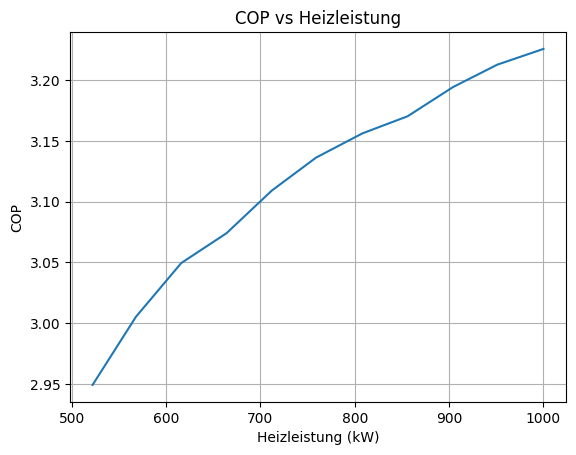

In [11]:
cops, Q_heizliste = calc_cop_genau()
plt.plot(Q_heizliste, cops)
plt.xlabel("Heizleistung (kW)")
plt.ylabel("COP")
plt.title("COP vs Heizleistung")
plt.grid(True)
plt.show()

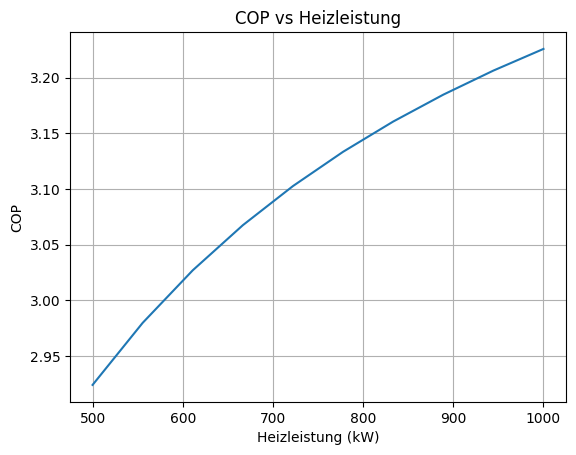

In [12]:
cops, Q_heizliste = calc_cop(P_db2, P_db)
plt.plot(Q_heizliste, cops)
plt.xlabel("Heizleistung (kW)")
plt.ylabel("COP")
plt.title("COP vs Heizleistung")
plt.grid(True)
plt.show()

# **Rohrdimensionierung**
+ **Kältemittelgeschwindigkeiten in m/s**
  + Saugleitung = 4,5 - 20
  + Druckleitung 10 - 18
  + Flüssigkeitsleitungen <1,5

+ **Rohrdurchmesserberechnung**:
  - $\dot{m} = \rho \cdot w \cdot A$
  - $A = \pi \cdot \frac{d^2}{4}$
  - $d = \sqrt{\frac{4 \cdot \dot{m}}{\pi \cdot \rho \cdot w}}$

In [13]:
# Berechnung Rohrdurchmesser nach geschw. und dichte
w_s = [4.5, 20]
w_d = [10, 18]
w_fl = [1, 1.5]


def calc_d(m_dot, rho, w):
    d = []
    for wi in w:
        d.append(((4 * (m_dot)) / (np.pi * wi * rho)) ** 0.5 * 1000)
    return np.array(d)


d_s = calc_d(m_dot, rho[0], w_s)
d_d = calc_d(m_dot, rho[1], w_d)
d_fl = calc_d(m_dot, rho[2], w_fl)
d_fl2 = calc_d(m_dot, rho[4], w_fl)

d_s_teil = calc_d(m_dot * 0.6, rho[0], w_s)
d_d_teil = calc_d(m_dot * 0.6, rho[1], w_d)
d_fl_teil = calc_d(m_dot * 0.6, rho[2], w_fl)
d_fl2_teil = calc_d(m_dot * 0.6, rho[4], w_fl)
print("Volllast:")
print(f"Rohrdurchmesser Saugseite: {d_s[0]:.2f} mm, {d_s[1]:.2f} mm")
print(f"Rohrdurchmesser Druckseite: {d_d[0]:.2f} mm, {d_d[1]:.2f} mm")
print(f"Rohrdurchmesser Flüssigkeit: {d_fl[0]:.2f} mm, {d_fl[1]:.2f} mm")
print(f"Rohrdurchmesser Flüssigkeit 2: {d_fl2[0]:.2f} mm, {d_fl2[1]:.2f} mm")
print("Teillast:")
print(f"Rohrdurchmesser Saugseite Teillast: {d_s_teil[0]:.2f} mm, {d_s_teil[1]:.2f} mm")
print(
    f"Rohrdurchmesser Druckseite Teillast: {d_d_teil[0]:.2f} mm, {d_d_teil[1]:.2f} mm"
)
print(
    f"Rohrdurchmesser Flüssigkeit Teillast: {d_fl_teil[0]:.2f} mm, {d_fl_teil[1]:.2f} mm"
)
print(
    f"Rohrdurchmesser Flüssigkeit 2 Teillast: {d_fl2_teil[0]:.2f} mm, {d_fl2_teil[1]:.2f} mm"
)

Volllast:
Rohrdurchmesser Saugseite: 287.06 mm, 136.17 mm
Rohrdurchmesser Druckseite: 76.81 mm, 57.25 mm
Rohrdurchmesser Flüssigkeit: 44.36 mm, 36.22 mm
Rohrdurchmesser Flüssigkeit 2: 41.36 mm, 33.77 mm
Teillast:
Rohrdurchmesser Saugseite Teillast: 222.36 mm, 105.47 mm
Rohrdurchmesser Druckseite Teillast: 59.50 mm, 44.35 mm
Rohrdurchmesser Flüssigkeit Teillast: 34.36 mm, 28.06 mm
Rohrdurchmesser Flüssigkeit 2 Teillast: 32.04 mm, 26.16 mm


# Wärmeübertrager Schaubilder

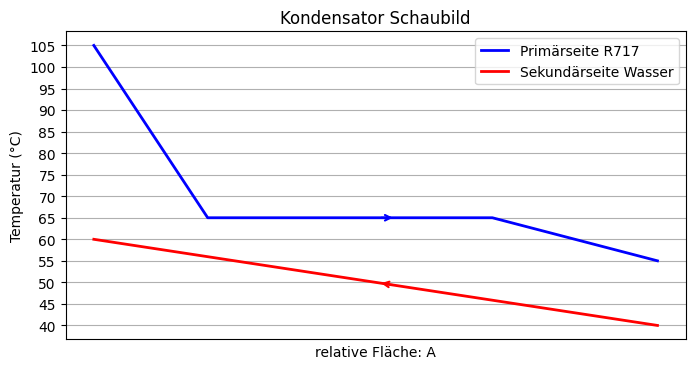

In [14]:
# Definition der Variablen
x = np.linspace(0, 10, 100)
# Beispielhafte Temperaturverläufe
# y1_new: Start bei 105°C, Plateau bei 65°C, dann linear auf 55°C
y1_new = np.concatenate(
    [
        np.linspace(105, 65, 21),  # von 105°C auf 65°C (21 Werte)
        np.full(49, 65),  # Plateau bei 65°C (49 Werte)
        np.linspace(65, 55, 30),  # von 65°C auf 55°C (30 Werte)
    ]
)
y1_new = y1_new[:100]  # auf Länge von x beschränken
# y2_new: linear von 60°C auf 40°C
y2_new = np.linspace(60, 40, 100)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, y1_new, label="Primärseite R717", color="blue", linewidth=2)
plt.plot(x, y2_new, label="Sekundärseite Wasser", color="r", linewidth=2)

# Automatisch orientierte Pfeile für Primärseite
i = len(x) // 2  # 50% der Linie
dx = x[i + 5] - x[i - 5]  # Richtung berechnen
dy = y1_new[i + 5] - y1_new[i - 5]
plt.annotate(
    "",
    xy=(x[i] + dx * 0.3, y1_new[i] + dy * 0.3),
    xytext=(x[i], y1_new[i]),
    arrowprops=dict(arrowstyle="->", lw=1.5, color="blue"),
)

# Automatisch orientierte Pfeile für Sekundärseite
i = len(x) // 2  # 50% der Linie
dx = x[i + 5] - x[i - 5]
dy = y2_new[i + 5] - y2_new[i - 5]
plt.annotate(
    "",
    xy=(x[i] + dx * 0.3, y2_new[i] + dy * 0.3),
    xytext=(x[i], y2_new[i]),
    arrowprops=dict(arrowstyle="<-", lw=1.5, color="red"),
)

plt.xlabel("relative Fläche: A")
plt.ylabel("Temperatur (°C)")
plt.title("Kondensator Schaubild")
plt.legend()
plt.xticks([])
plt.yticks(np.arange(40, 110, 5))
plt.grid(True)
plt.show()

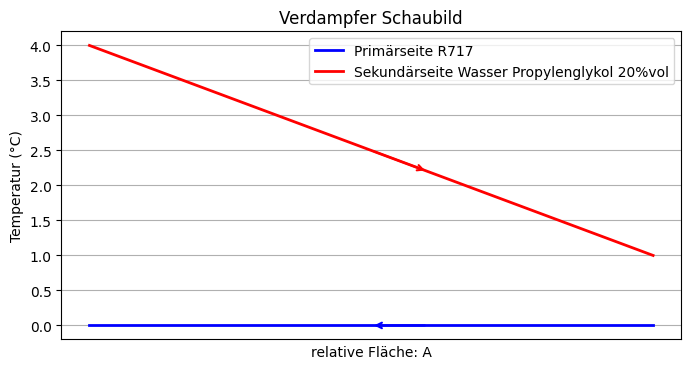

In [15]:
plt.figure(figsize=(8, 4))

# Temperaturverlauf von T[4] zu T[1]
x_verd = [0, 1]
y1_verd = [T[4] - 273.15, T[0] - 273.15]
y2_verd = [4, 1]

plt.plot(x_verd, y1_verd, label="Primärseite R717", color="blue", linewidth=2)
plt.plot(
    x_verd,
    y2_verd,
    label="Sekundärseite Wasser Propylenglykol 20%vol",
    color="r",
    linewidth=2,
)

# Automatisch orientierte Pfeile für Primärseite (R717)
dx1 = x_verd[1] - x_verd[0]
dy1 = y1_verd[1] - y1_verd[0]
plt.annotate(
    "",
    xy=(0.5 + dx1 * 0.1, y1_verd[0] + dy1 * 0.5 + dy1 * 0.1),
    xytext=(0.5, y1_verd[0] + dy1 * 0.5),
    arrowprops=dict(arrowstyle="<-", lw=1.5, color="blue"),
)

# Automatisch orientierte Pfeile für Sekundärseite (Wasser)
dx2 = x_verd[1] - x_verd[0]
dy2 = y2_verd[1] - y2_verd[0]
plt.annotate(
    "",
    xy=(0.5 + dx2 * 0.1, y2_verd[0] + dy2 * 0.5 + dy2 * 0.1),
    xytext=(0.5, y2_verd[0] + dy2 * 0.5),
    arrowprops=dict(arrowstyle="->", lw=1.5, color="red"),
)

plt.xlabel("relative Fläche: A")
plt.ylabel("Temperatur (°C)")
plt.title("Verdampfer Schaubild")
plt.legend()
plt.xticks([])
plt.grid(True)
plt.show()

# Füllvolumen Berechnung
+ Kondensator 28,5 * 2 L
+ Verdampfer 335,605 L 
+ Verdichter
+ Sammler 1
+ Sammler 2

In [16]:
# Füllmengenformel
def calc_Füll(V, phi, rho_l, rho_g):
    M = phi * V * rho_l + (1 - phi) * V * rho_g
    return M  # M in Kg

In [17]:
# Kondensator Füllmenge
phi_cond = 0.35
V_cond = 28.5 * 2 * 1e-3  # mal 2 wegen 2 units in Parallelschaltung
M_cond = calc_Füll(V_cond, phi_cond, rho[2], rho[1])  # Füllung Kondensator

In [18]:
# Verdampfer Füllmenge
phi_evap = 0.8
V_evap = 335.605e-3
M_evap = calc_Füll(V_evap, phi_evap, rho[4], rho[0])  # Füllung Verdampfer

In [19]:
# Verdichter Füllmenge
phi_v = 0.5
V_v = 0.75

M_v = calc_Füll(V_v, phi_v, rho[0], rho[1])

In [20]:
# Rohr Füllstand
def calc_Füll_rohr(d, rho, length):
    V = np.pi * (d / 2) ** 2 * length  # Volumen des Rohrs in m³
    M = V * rho  # Füllmenge in kg
    return M  # M in Kg

In [21]:
# Saugseite Füllmenge
d_s = 150e-3
l_s = 5
rho_s = rho[0]
M_s = calc_Füll_rohr(d_s, rho_s, l_s)  # Füllung Saugseite
print(M_s, "kg")

0.26036461169673 kg


In [22]:
d_d = 58e-3
l_d = 3
rho_d = rho[1]
M_d = calc_Füll_rohr(d_d, rho_d, l_d)  # Füllung Druckseite
print(M_d, "kg")

0.14679728669242634 kg


In [23]:
d_l = 38e-3
l_l = 3.5
rho_l = rho[2]
M_l = calc_Füll_rohr(d_l, rho_l, l_l)  #
print(M_l, "kg")

2.2040851638209 kg


In [24]:
d_l2 = 38e-3
l_l2 = 3.5
rho_l2 = rho[3]
M_l2 = calc_Füll_rohr(d_l2, rho_l2, l_l2)  #
print(M_l2, "kg")

0.0638118098378002 kg


In [25]:
d_ev1 = 38e-3
l_ev1 = 2.5
rho_ev1 = rho[4]
M_ev1 = calc_Füll_rohr(d_ev1, rho_ev1, l_ev1)  # Füllung Verdampfer 1
print(M_ev1, "kg")

1.8107228361730534 kg


In [26]:
d_ev2 = 38e-3
l_ev2 = 2.5
rho_ev2 = rho[0]
M_ev2 = calc_Füll_rohr(d_ev2, rho_ev2, l_ev2)  # Füllung Verdampfer 2
print(M_ev2, "kg")

0.008354811095335066 kg


In [27]:
M_rohr = M_s + M_d + M_l + M_l2 + M_ev1 + M_ev2
print(f"Füllmenge Rohrleitungen: {M_rohr:.2f} kg")

Füllmenge Rohrleitungen: 4.49 kg


In [28]:
M = (M_cond + M_evap + M_v + M_rohr) * 2

In [29]:
print(f"Füllmenge Kondensator: {M_cond:.2f} kg")
print(f"Füllmenge Verdampfer: {M_evap:.2f} kg")
print(f"Füllmenge Verdichter: {M_v:.2f} kg")
print(f"Füllmenge Rohrleitungen: {M_rohr:.2f} kg")
print(f"Gesamtfüllmenge: {M:.2f} kg")

Füllmenge Kondensator: 11.76 kg
Füllmenge Verdampfer: 171.66 kg
Füllmenge Verdichter: 8.05 kg
Füllmenge Rohrleitungen: 4.49 kg
Gesamtfüllmenge: 391.94 kg
